# Exercises

file name: time_series_anomaly_detection.py or time_series_anomaly_detection.ipynb

Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.

Bonus:

Can you label students who are viewing both the web dev and data science curriculum? Can you label students by the program they are in? Can you label users by student vs. staff? What are Zach, Maggie, Faith, and Ryan's ids?

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #to format dates on our plots
import seaborn as sns

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()

# Wrangle Data

In [2]:
# this works
# assign column names for incoming file
colnames=['date', 'hour', 'page_viewed', 'user_id', 'cohort', 'IP']
# read in data
df = pd.read_csv('anonymized-curriculum-access.txt', sep=' ', header=None, names=colnames)

In [3]:
# merge date and hour together with a space between for later datetime conversion
df['date_time'] = df['date'] + ' ' + df['hour']

In [4]:
# delete the original date and hour columns now that they are in 1 column
del df['date']
del df['hour']

In [5]:
# convert the date_time to a datetime tpye
df.date_time = pd.to_datetime(df.date_time) 
# this will set the date_time as the index, but not sure I want to do that yet
# this step is needed for split and other columns needed in train, add back in
df = df.set_index('date_time')

In [6]:
# check where we are so far
df.head()

,page_viewed,user_id,cohort,IP
date_time,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [7]:
# verify column types
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 719459 entries, 2018-01-26 09:55:03 to 2020-11-02 16:48:47
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   page_viewed  719458 non-null  object 
 1   user_id      719459 non-null  int64  
 2   cohort       674619 non-null  float64
 3   IP           719459 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 27.4+ MB


In [8]:
# look for nulls
df.isna().sum()

page_viewed        1
user_id            0
cohort         44840
IP                 0
dtype: int64

In [9]:
# create a dataframe of all those missing a cohort id for later review
missing_cohort = df[df['cohort'].isnull()]
missing_cohort

,page_viewed,user_id,cohort,IP
date_time,,,,
2018-01-26 16:46:16,/,48,NaN,97.105.19.61
2018-01-26 16:46:24,spring/extra-features/form-validation,48,NaN,97.105.19.61
2018-01-26 17:54:24,/,48,NaN,97.105.19.61
2018-01-26 18:32:03,/,48,NaN,97.105.19.61
2018-01-26 18:32:17,mysql/relationships/joins,48,NaN,97.105.19.61
...,...,...,...,...
2020-11-02 16:02:22,java-iii,717,NaN,136.50.18.157
2020-11-02 16:02:26,java-iii/servlets,717,NaN,136.50.18.157
2020-11-02 16:03:50,appendix/further-reading/java/intellij-tomcat-...,727,NaN,70.94.165.107


In [10]:
# almost 45,000 records missing cohort id, fill with 0 for now
df = df.fillna(0)
# change to integer instead of float
df.cohort = df.cohort.astype('int')

In [11]:
# verify column types
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 719459 entries, 2018-01-26 09:55:03 to 2020-11-02 16:48:47
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   page_viewed  719459 non-null  object
 1   user_id      719459 non-null  int64 
 2   cohort       719459 non-null  int64 
 3   IP           719459 non-null  object
dtypes: int64(2), object(2)
memory usage: 27.4+ MB


### compute entropy

In [12]:
# function to compute entropy from lesson

def compute_entropy(series):
    counts = series.value_counts()
    if len(counts)==1:
        ent = 0
    else:
        value, counts = np.unique(series, return_counts=True)
        ent = entropy(counts, base=None)
    return ent

In [13]:
compute_entropy(df.IP)

4.281933437860451

In [14]:
compute_entropy(df.cohort)

3.235242786918197

In [15]:
compute_entropy(df.user_id)

6.170031470548415

all of these values are 1 or higher indicating high variability in the data

### Split data?

- not sure if this is the right place to split, but want to move into Explore so will split here
- spliting this way doesn't work if date_time is not set as the index
- also cant' add day, month, etc. columns without date_time as index


In [16]:
# split by human specified date, played around to get even looking valiadate and test
train = df[:'2019-07-17']
validate = df['2019-07-18':'2020-03-15']
test = df['2020-03-16':]

In [17]:
train.head()

,page_viewed,user_id,cohort,IP
date_time,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61


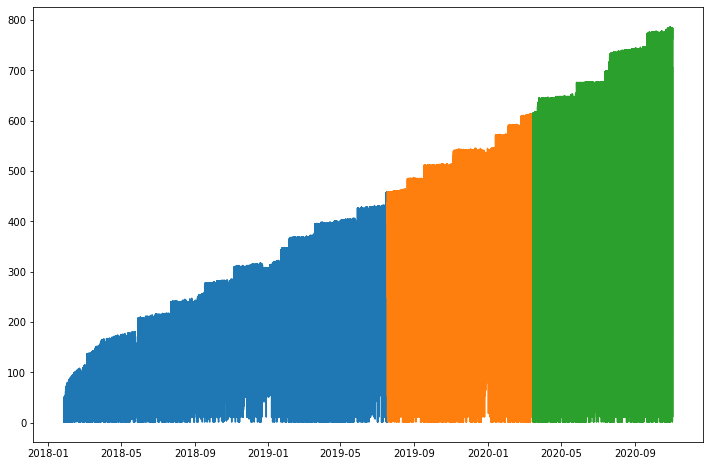

In [18]:
# view size of splits
plt.figure(figsize=(12, 8))
plt.plot(train.user_id)
plt.plot(validate.user_id)
plt.plot(test.user_id)
plt.show()

# Explore

### how many occurances by each IP?

- return to add % probability of seeing that IP in the dataset

In [19]:
train.IP.value_counts()
# https://iplocation.com/
# https://iplocation.com/
# 3rd IP listed is for Codeup downtown

97.105.19.58       155236
97.105.19.61        61662
192.171.117.210      6887
66.69.108.117        1175
70.122.40.62         1156
                    ...  
24.214.254.244          1
104.237.80.106          1
172.58.109.223          1
89.187.164.76           1
64.250.227.83           1
Name: IP, Length: 2088, dtype: int64

#### return here

In [20]:
# not sure what to do with this
train_agg = train.groupby(['user_id','cohort'])['page_viewed'].\
                        nunique().\
                    reset_index().\
                    rename(index=str, 
                       columns={'page_viewed': 'unique_pages'})

In [21]:
train_agg
# this is the number of unique pages a particular user_id visited by cohort
# return to this later

,user_id,cohort,unique_pages
0,1,8,248
1,1,28,417
2,2,22,151
3,3,22,169
4,4,22,143
...,...,...,...
472,454,33,9
473,455,33,7
474,456,33,8
475,457,33,8


In [22]:
# add these columns for exploring
train['month'] = train.index.month
train['weekday'] = train.index.day_name()
train['hour'] = train.index.hour
train['day'] = train.index.day
train['year'] = train.index.year


In [23]:
train.head()

,page_viewed,user_id,cohort,IP,month,weekday,hour,day,year
date_time,,,,,,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61,1,Friday,9,26,2018
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,1,Friday,9,26,2018
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,1,Friday,9,26,2018
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,1,Friday,9,26,2018
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,1,Friday,9,26,2018


### what time of day do most occurrences for a cohort happen?

<AxesSubplot:xlabel='cohort', ylabel='hour'>

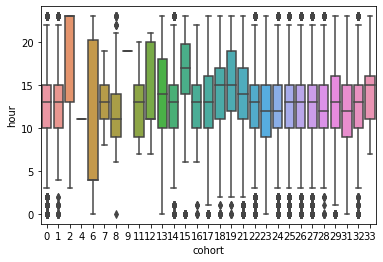

In [24]:
sns.boxplot(data=train, y='hour', x='cohort')

### is there a different number of occurrences by cohort and day of week?

<AxesSubplot:xlabel='cohort', ylabel='weekday'>

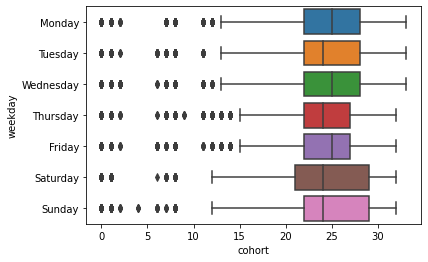

In [25]:
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(data=train, y='weekday', x='cohort', order=order)

#### return here

In [26]:
# how many occurances are there by cohort?
train.cohort.value_counts()
# which cohorts have the fewest occurances?
# 9 and 4
# conjecture these cohorts graduated before the start of this dataset and there have only been a
# few reference look ups from someone in that group
# could check number of user_id for those cohorts to see if same or various

24    34754
29    34304
22    28550
23    27301
26    25780
0     25184
25    24917
31    20697
27    19932
32    12156
28    11466
1      8856
14     7861
21     6809
17     2892
13     2299
8      1671
18     1500
19     1066
33      775
16      740
15      682
7       407
12      249
11      174
2        89
6        72
9         5
4         4
Name: cohort, dtype: int64

In [27]:
# create a copy of train with datetime index for later use
traindt = train.copy()

In [28]:
# What is the first and last access date by cohort?
train.head()

,page_viewed,user_id,cohort,IP,month,weekday,hour,day,year
date_time,,,,,,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61,1,Friday,9,26,2018
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,1,Friday,9,26,2018
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,1,Friday,9,26,2018
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,1,Friday,9,26,2018
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,1,Friday,9,26,2018


In [29]:
# reset index so it is not datetime
train = train.reset_index()

In [30]:
# create dataframe by cohort with count of unique users, count of pages viewed, first date accessed, and
# last date accessed
tcohort = train.groupby(['cohort'])['user_id', 'page_viewed', 'date_time'].\
                        agg({'user_id' : ['nunique'], 'page_viewed': ['count'], 'date_time' : ['min', 'max']})

# use this to unstack the column names
tcohort.columns = [' '.join(col).strip() for col in tcohort.columns.values]

# use this for multiple aggregation
# # df.agg({'A' : ['sum', 'min'], 'B' : ['min', 'max']})

In [31]:
tcohort.reset_index()

,cohort,user_id nunique,page_viewed count,date_time min,date_time max
0,0,49,25184,2018-01-26 16:46:16,2019-07-17 17:26:00
1,1,18,8856,2018-01-26 10:14:47,2019-07-14 08:57:59
2,2,3,89,2018-03-19 03:09:52,2019-03-22 23:37:25
3,4,1,4,2018-02-04 11:21:38,2018-02-04 11:24:56
4,6,2,72,2018-10-16 03:56:59,2019-05-12 21:40:52
5,7,5,407,2018-01-31 19:09:55,2019-06-20 11:22:22
6,8,4,1671,2018-01-26 09:55:03,2018-12-05 08:01:42
7,9,1,5,2018-03-22 19:01:49,2018-03-22 19:02:52
8,11,4,174,2018-05-07 20:12:30,2019-06-27 10:44:44
9,12,4,249,2018-02-15 19:51:45,2019-07-13 15:12:53


In [32]:
#### return here

In [33]:
# mask = (df.column.str.contains(“A”) | df.column.str.contains(“B”))
# df[mask]

In [34]:
traindt.head()

,page_viewed,user_id,cohort,IP,month,weekday,hour,day,year
date_time,,,,,,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61,1,Friday,9,26,2018
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,1,Friday,9,26,2018
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,1,Friday,9,26,2018
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,1,Friday,9,26,2018
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,1,Friday,9,26,2018


In [53]:
john = traindt.copy()

In [54]:
john['accesses'] = 1

In [55]:
john.head()

,page_viewed,user_id,cohort,IP,month,weekday,hour,day,year,accesses
date_time,,,,,,,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61,1,Friday,9,26,2018,1
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,1,Friday,9,26,2018,1
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,1,Friday,9,26,2018,1
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,1,Friday,9,26,2018,1
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,1,Friday,9,26,2018,1


### what is the number of pages viewed by user_id per day?

In [35]:
day = traindt.copy()
#df = df[['size']].resample('1d').sum()

In [36]:
day = day[['page_viewed']].resample('1d').count()

In [37]:
day = day.fillna(value=0)
day.columns = ['occurrences']

In [38]:
day.head()

,occurrences
date_time,
2018-01-26,572
2018-01-27,230
2018-01-28,170
2018-01-29,830
2018-01-30,652


#### Simple Moving Average

In [39]:
# SMA = 1 week
sma_short = day.rolling(window=7).mean()
sma_short[:10]

,occurrences
date_time,
2018-01-26,NaN
2018-01-27,NaN
2018-01-28,NaN
2018-01-29,NaN
2018-01-30,NaN
2018-01-31,NaN
2018-02-01,576.714286
2018-02-02,595.857143
2018-02-03,598.571429


In [40]:
sma_long = day.rolling(window=30).mean()
sma_long[27:33]

,occurrences
date_time,
2018-02-22,NaN
2018-02-23,NaN
2018-02-24,482.000000
2018-02-25,469.533333
2018-02-26,475.766667
2018-02-27,509.133333


Text(0, 0.5, 'occurrences')

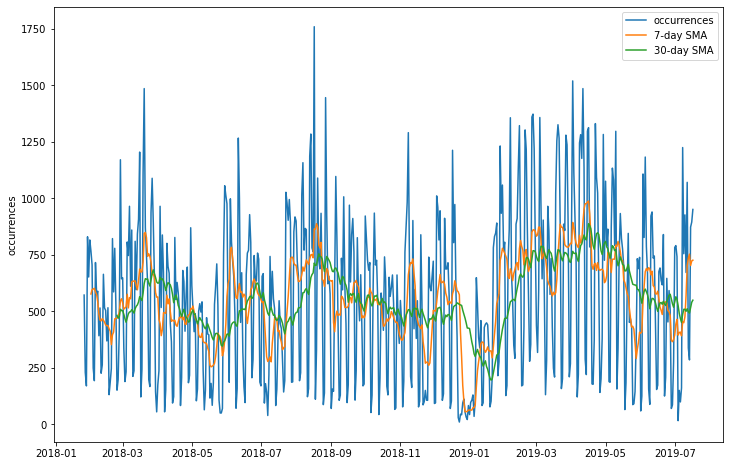

In [41]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(day.index, day, label='occurrences')

ax.plot(day.index, sma_short, label = '7-day SMA')

ax.plot(day.index, sma_long, label = '30-day SMA')

ax.legend(loc='best')
ax.set_ylabel('occurrences')

#### Exponential Moving Average

In [42]:
ema_short = day.ewm(span=7).mean()
ema_short.head()

,occurrences
date_time,
2018-01-26,572.000000
2018-01-27,376.571429
2018-01-28,287.243243
2018-01-29,485.737143
2018-01-30,540.235595


In [43]:
ema_long = day.ewm(span=30).mean()
ema_long.tail()

,occurrences
date_time,
2019-07-13,553.981541
2019-07-14,536.627893
2019-07-15,558.329319
2019-07-16,580.050008
2019-07-17,603.982266


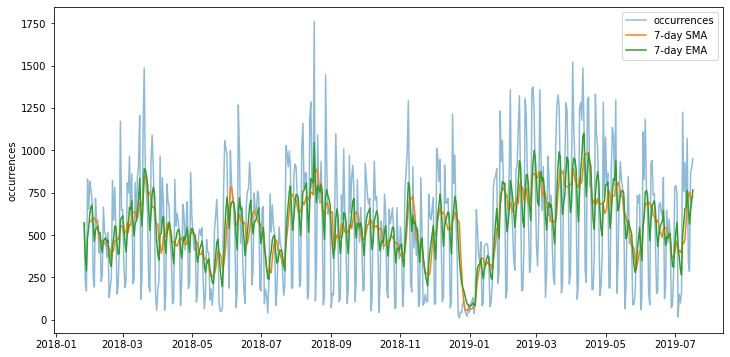

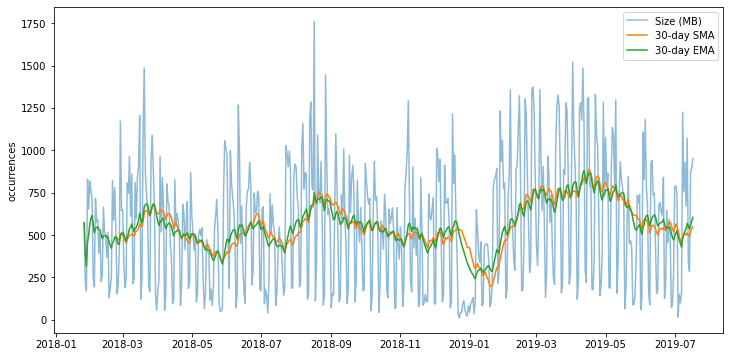

In [44]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(day.index, day, label='occurrences', alpha=.5)

ax.plot(day.index, sma_short, label = '7-day SMA')
ax.plot(day.index, ema_short, label = '7-day EMA')

ax.legend(loc='best')
ax.set_ylabel('occurrences')

plt.show()

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(day.index, day, label='Size (MB)', alpha=.5)

ax.plot(day.index, sma_long, label = '30-day SMA')
ax.plot(day.index, ema_long, label = '30-day EMA')

ax.legend(loc='best')
ax.set_ylabel('occurrences')

plt.show()

#### Chart SMA and EMA

#### Bolinger bands and %b

In [45]:
# set the window span - in this case 30 days
span = 30

# compute midband
midband = day.ewm(span=span).mean()
midband

,occurrences
date_time,
2018-01-26,572.000000
2018-01-27,395.300000
2018-01-28,315.139578
2018-01-29,457.002386
2018-01-30,501.369064
...,...
2019-07-13,553.981541
2019-07-14,536.627893
2019-07-15,558.329319


In [46]:
# compute exponential stdev
stdev = day.ewm(span=span).std()
stdev

,occurrences
date_time,
2018-01-26,NaN
2018-01-27,241.830519
2018-01-28,213.878138
2018-01-29,316.467837
2018-01-30,284.479727
...,...
2019-07-13,362.636966
2019-07-14,357.125434
2019-07-15,355.491995


In [47]:
# compute upper and lower bands, multiple the midband +/- 3 times the standard deviation
ub = midband + stdev*3
lb = midband - stdev*3

ub

,occurrences
date_time,
2018-01-26,NaN
2018-01-27,1120.791557
2018-01-28,956.773991
2018-01-29,1406.405897
2018-01-30,1354.808245
...,...
2019-07-13,1641.892440
2019-07-14,1608.004194
2019-07-15,1624.805306


Text(0, 0.5, 'occurrences')

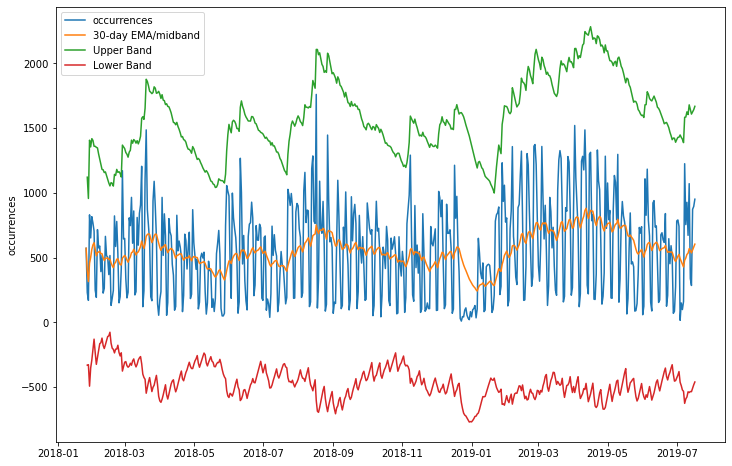

In [48]:
# plot the bands
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(day.index, 
        day,
        label='occurrences')

ax.plot(day.index, 
        midband, 
        label = '30-day EMA/midband')
ax.plot(day.index, 
        ub, 
        label = 'Upper Band')
ax.plot(day.index, 
        lb, 
        label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('occurrences')

In [49]:
# concat the dataframes together
day = pd.concat([day, midband, ub, lb], axis=1)
day.columns = ['occurrences', 'midband', 'ub', 'lb']
day.tail()

,occurrences,midband,ub,lb
date_time,,,,
2019-07-13,338,553.981541,1641.892440,-533.929358
2019-07-14,285,536.627893,1608.004194,-534.748408
2019-07-15,873,558.329319,1624.805306,-508.146667
2019-07-16,895,580.050008,1641.974525,-481.874508
2019-07-17,951,603.982266,1668.055356,-460.090824


In [50]:
# add a calculated column for %b
day['pct_b'] = (day['occurrences'] - day['lb'])/(day['ub'] - day['lb'])

In [51]:
# show anywhere %b is more than 1 = outside the upper band
day[day['pct_b']>1]
# there are no results that are outside the band

,occurrences,midband,ub,lb,pct_b
date_time,,,,,


In [52]:
# show anywhere %b is more than .9 = right at the upper band
day[day['pct_b']>.9]
# there are no results for this either

,occurrences,midband,ub,lb,pct_b
date_time,,,,,
